# Autoregression

## we will use autoregression and attempt to predict the S&P 500 closing price 1 year into the future

In [1]:
# import packages
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import warnings

In [2]:
# load data
df = pd.read_csv('spx.csv')
df.head()

,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97


In [3]:
df.dtypes

date      object
close    float64
dtype: object

In [4]:
# converting date column into datetime data type
df.date = pd.to_datetime(df['date'])

In [5]:
df.dtypes

date     datetime64[ns]
close           float64
dtype: object

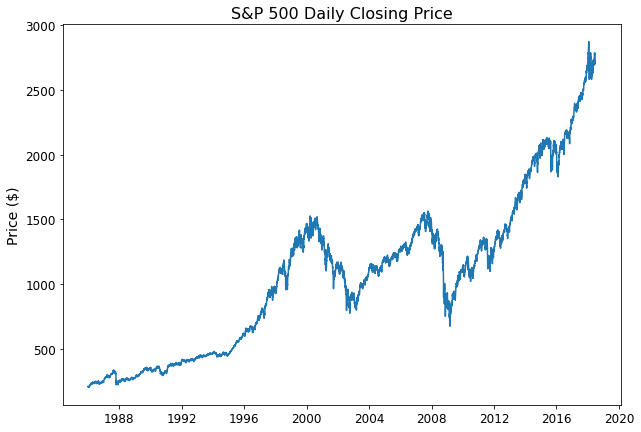

In [6]:
# plot raw data
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(df.date, df.close)
ax.set_title('S&P 500 Daily Closing Price', 
             fontsize = 16)
ax.set_ylabel('Price ($)', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

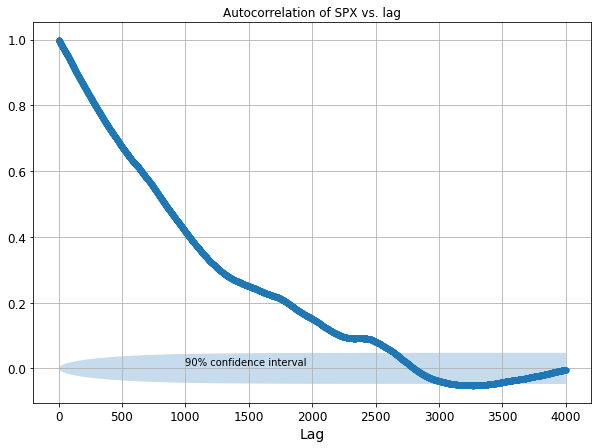

In [7]:
# Let's check if the model is able to be used as a regression against itself
max_lag = 4000
fig, ax = plt.subplots(figsize = (10, 7))
acf_plot = plot_acf(x = df.close,
                    ax = ax,
                    lags = max_lag,
                    use_vlines = False,
                    alpha = 0.9,
                    title = 'Autocorrelation of SPX vs. lag')
ax.grid(True)
ax.text(1000, 0.01, '90% confidence interval')
ax.set_xlabel('Lag', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

To get some intuition for the ACF results, let's choose a fairly short lag of 100 days and plot both the original data and the lagged data on one chart

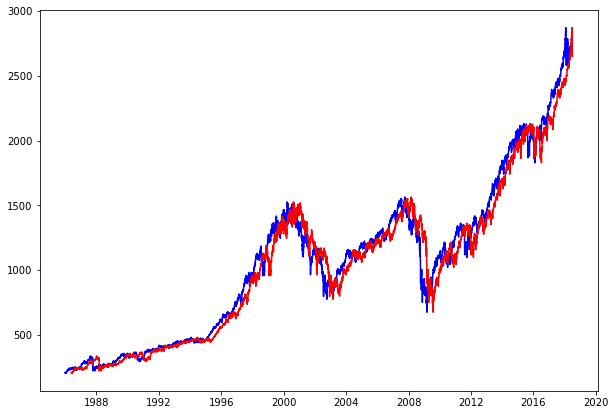

In [8]:
spx_shift_100 = df.copy()
spx_shift_100['close'] = df.close.shift(100)
fix, ax = plt.subplots(figsize = (10, 7))
ax.plot(df.date, df.close, c = "blue")
ax.plot(spx_shift_100.date, spx_shift_100.close, c = "red")
plt.show()

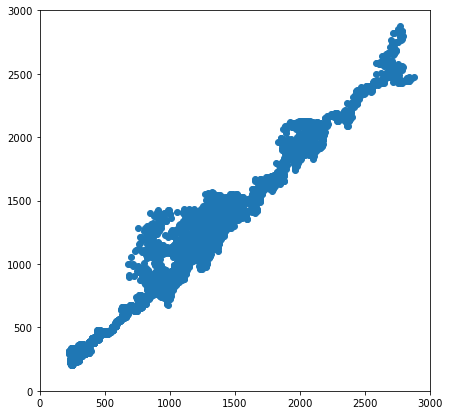

In [9]:
# plot the lagged values against the actual values
fig, ax = plt.subplots(figsize = (7, 7))
ax.scatter(df.loc[100:, 'close'], spx_shift_100.loc[100:, 'close'])
ax.set_xlim(0, 3000)
ax.set_ylim(0, 3000)
plt.show()

Figure shows that most of the values with a lag of 100 days are along a diagonal line, meaning that the relationship between the lagged values and the present values is similar across all actual values.

In [10]:
corr0 = np.correlate(df.close[0: ] - df.close.mean(), 
                     df.close[0: ] - df.close.mean(), 
                     mode = 'valid')
corrs = [np.correlate(df.close[:(df.close.shape[0] - i)] - df.close.mean(), 
                      df.close[i: ] - df.close.mean(), 
                      mode = 'valid')
        for i in range(max_lag)] / corr0

let's create a function to generate a grid of plots that we can use with various lag ranges, numbers of plots, and so on

In [11]:
def plot_lag_grid(series, corrs, axis_min, axis_max, num_plots, total_lag, n_rows, n_cols):
    lag_step = int(total_lag / num_plots)
    fig = plt.figure(figsize = (18, 16))
    for i in range(num_plots):
        corr = corrs[lag_step * i]
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        ax.scatter(series, series.shift(lag_step * i))
        ax.set_xlim(axis_min, axis_max)
        ax.set_ylim(axis_min, axis_max)
        ax.set_title('lag = ' + str(lag_step * i))
        ax.text(axis_min + 0.05 * (axis_max - axis_min),
                axis_max - 0.05 * (axis_max - axis_min),
                'correlation = ' + str(round(corr[0], 3)))
        fig.tight_layout()
    plt.show()

create a grid to see how well the data at increasing lags correlates to the original data

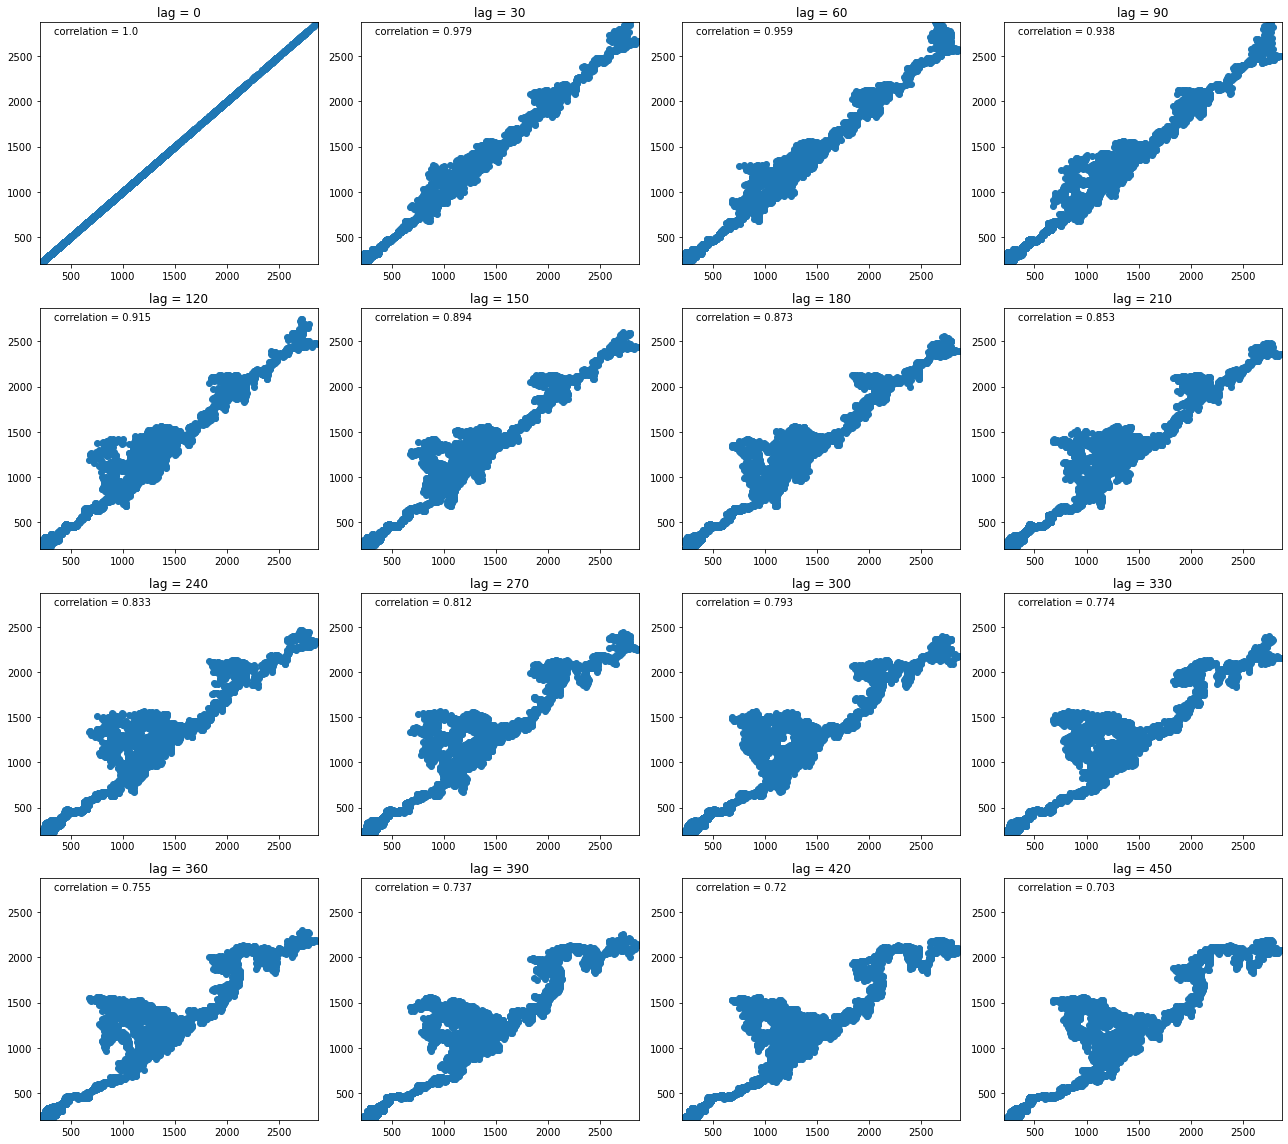

In [12]:
plot_lag_grid(df.close, corrs,
              df.close.min(), df.close.max(),
              num_plots = 16,
              total_lag = 480,
              n_rows = 4, n_cols = 4)

We can see a gradual degradation in lag chart appearance in direct relation to the ACF function value shown on each plot. This gives us the idea that trying to use longer lags will add noise to the model, which looks like it would be fairly large by lag 60, and not too large at lag 30.

The statsmodels function, AR, along with the associated fit method, builds an autoregression model.

In [13]:
model = AR(df.close)
model_fit = model.fit()

C:\Users\Hevans\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN,

In [14]:
max_lag = model_fit.k_ar

In [15]:
print('max Lag: ' + str(max_lag))
print('Coefficients: \n' + str(model_fit.params))

max Lag: 36
Coefficients: 
const        0.114237
L1.close     0.944153
L2.close     0.008452
L3.close     0.046900
L4.close    -0.014887
L5.close    -0.024734
L6.close     0.025849
L7.close    -0.004821
L8.close     0.009209
L9.close    -0.010451
L10.close    0.033449
L11.close   -0.029657
L12.close    0.052843
L13.close   -0.031489
L14.close   -0.023010
L15.close   -0.018195
L16.close    0.060165
L17.close    0.004425
L18.close   -0.057269
L19.close    0.025184
L20.close    0.008416
L21.close   -0.020273
L22.close    0.024271
L23.close   -0.010330
L24.close    0.004574
L25.close   -0.016035
L26.close    0.005954
L27.close    0.032375
L28.close   -0.037643
L29.close    0.024265
L30.close   -0.006099
L31.close   -0.018106
L32.close    0.005761
L33.close   -0.002750
L34.close   -0.037882
L35.close    0.046765
L36.close    0.000887
dtype: float64


In [16]:
# make predictions
max_forecast = 365

pred_close = pd.DataFrame({'pred_close': model_fit.predict(start = max_lag,
                                             end = df.shape[0] + max_forecast - 1)})

In [17]:
# attach the dates for visualization
pred_close['date'] = df['date'].reindex()
pred_close.loc[(max(df.index) + 1):, 'date'] = pd.to_datetime([max(df.date) + pd.Timedelta(days = i)
                                                               for i in range(1, max_forecast + 1)])

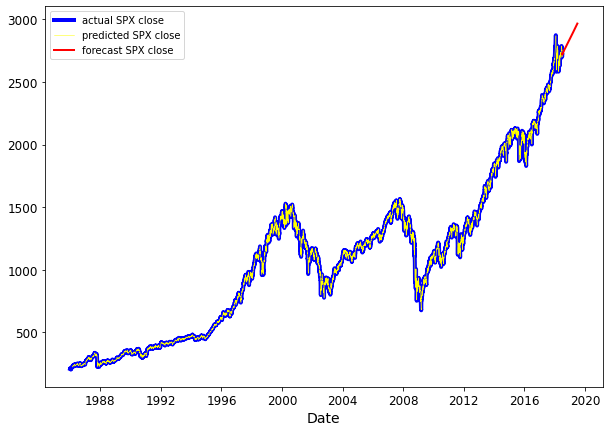

In [18]:
# visualizing real data and predictions
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(df.date, 
        df.close, 
        c = "blue", 
        linewidth = 4,
        label = 'actual SPX close')
ax.plot(pred_close.loc[0 : len(df.close), 'date'], 
        pred_close.loc[0 : len(df.close), 'pred_close'], 
        c = "yellow", 
        linewidth = 0.5,
        label = 'predicted SPX close')
ax.plot(pred_close.loc[len(df.close):, 'date'], 
        pred_close.loc[len(df.close):, 'pred_close'], 
        c = "red", 
        linewidth = 2,
        label = 'forecast SPX close')
ax.set_xlabel('Date', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)
ax.legend()
plt.show()

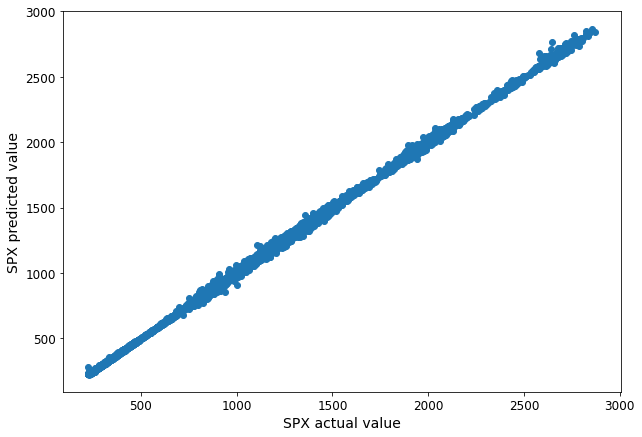

In [19]:
# We can use the same approach as for linear regression to compare the predictions versus the actual values
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(df.loc[max_lag:(df.shape[0] - 1), 'close'], 
pred_close.loc[max_lag:(df.shape[0] - 1), 'pred_close'])
ax.tick_params(axis = 'both', labelsize = 12)
ax.set_xlabel('SPX actual value', fontsize = 14)
ax.set_ylabel('SPX predicted value', fontsize = 14)
plt.show()

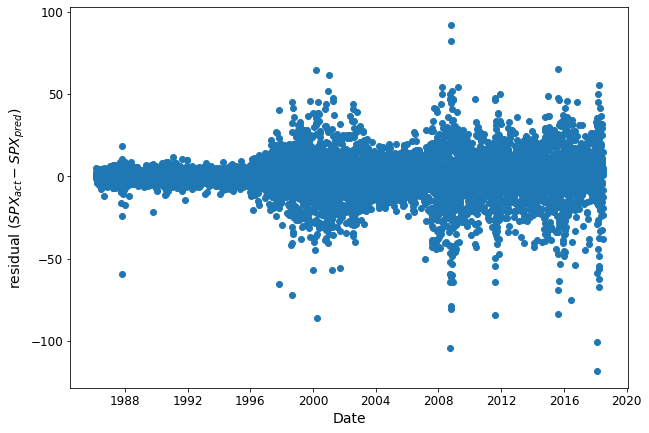

In [20]:
# Calculate the residuals
fig, ax = plt.subplots(figsize = (10, 7))
residuals = pd.DataFrame({'date' : (df.loc[max_lag:(df.shape[0] - 1), 'date']),
                          'residual' : df.loc[max_lag:(df.shape[0] - 1), 'close'] -
                          pred_close.loc[max_lag:(df.shape[0] - 1), 'pred_close']})
ax.scatter(residuals.date, residuals.residual)
ax.tick_params(axis = 'both', labelsize = 12)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('residual (' + r'$SPX_{act} - SPX_{pred}$' + ')', fontsize = 14)
plt.show()

Figure shows that the residuals are uniformly spread around 0, meaning that there appears to be minimal bias in the model, and they seem to increase somewhat over time

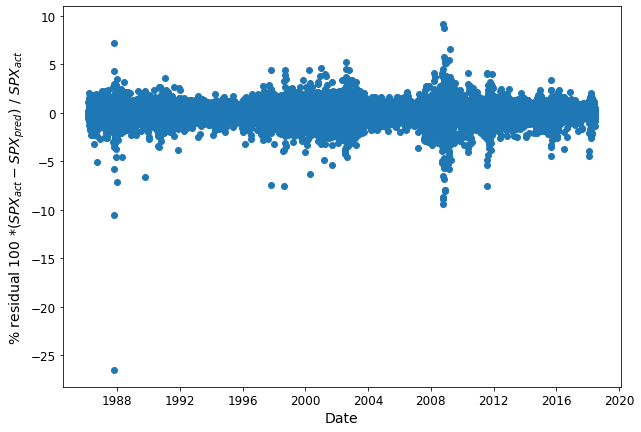

In [21]:
# Calculate the percentage of residuals simply by dividing by the actual value (and multiplying by 100)
fig, ax = plt.subplots(figsize = (10, 7))
pct_residuals = pd.DataFrame({'date' : residuals.date,
                              'pct_residual' : 100 * residuals.residual / 
                              df.loc[max_lag:(df.shape[0] - 1), 'close']})
ax.scatter(pct_residuals.date, pct_residuals.pct_residual)
ax.tick_params(axis = 'both', labelsize = 12)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('% residual 100 *(' + r'$SPX_{act} - SPX_{pred}$' + ') / ' + r'$SPX_{act}$', fontsize = 14)
plt.show()